### Step 1: Importing libraries

In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

DATA_PATH = '.'
CLIENTS_FILE = os.path.join(DATA_PATH, 'clients.csv')

### Step 2: Importing data

In [2]:
try:
    clients_df = pd.read_csv(CLIENTS_FILE)
except FileNotFoundError:
    print(f"ОШИБКА: Файл {CLIENTS_FILE} не найден.")

clients_df.head()

,client_code,name,status,age,city,avg_monthly_balance_KZT
0,1,Айгерим,Зарплатный клиент,29,Алматы,92643
1,2,Данияр,Премиальный клиент,41,Астана,1577073
2,3,Сабина,Студент,22,Алматы,63116
3,4,Тимур,Зарплатный клиент,36,Караганда,83351
4,5,Камилла,Премиальный клиент,45,Алматы,1336536


### Step 3: EDA and Feature engineering

In [3]:
aggregated_data = []
direct_signals_counter = Counter()

DIRECT_SIGNAL_TYPES = [
    'loan_payment_out', 'cc_repayment_out', 'installment_payment_out',
    'fx_buy', 'fx_sell', 'invest_out', 'invest_in', 
    'gold_buy_out', 'gold_sell_in'
]

print(f"Начинаем обработку данных {len(clients_df)} клиентов с корректным расчетом...")

for _, client in clients_df.iterrows():
    client_code = client['client_code']
    
    try:
        trans_file = os.path.join(DATA_PATH, f'client_{client_code}_transactions_3m.csv')
        transfers_file = os.path.join(DATA_PATH, f'client_{client_code}_transfers_3m.csv')
        
        transactions = pd.read_csv(trans_file)
        transfers = pd.read_csv(transfers_file)
    except FileNotFoundError:
        continue

    # --- КОРРЕКТНЫЙ РАСЧЕТ ПОТОКОВ ---
    
    # 1. Полный приток
    total_inflows = transfers[transfers['direction'] == 'in']['amount'].sum()
    
    # 2. Полный отток
    outflows_from_transfers = transfers[transfers['direction'] == 'out']['amount'].sum()
    outflows_from_transactions = transactions['amount'].sum() # <<< ИЗМЕНЕНИЕ ЗДЕСЬ
    total_outflows = outflows_from_transfers + outflows_from_transactions # <<< ИЗМЕНЕНИЕ ЗДЕСЬ
    
    # 3. Истинный чистый поток
    net_flow = total_inflows - total_outflows # <<< ИЗМЕНЕНИЕ ЗДЕСЬ

    # Остальные метрики
    volatile_outflows = transfers[transfers['type'].isin(['atm_withdrawal', 'p2p_out'])]['amount'].sum()
    stability_ratio = volatile_outflows / total_outflows if total_outflows > 0 else 0
    
    fx_transfers_sum = transfers[transfers['type'].isin(['fx_buy', 'fx_sell'])]['amount'].sum()
    foreign_currency_spend = transactions[transactions['currency'] != 'KZT']['amount'].sum()
    
    found_signals = set(transfers['type']).intersection(DIRECT_SIGNAL_TYPES)
    for signal in found_signals:
        direct_signals_counter[signal] += 1
    
    aggregated_data.append({
        'client_code': client_code,
        'avg_monthly_balance_KZT': client['avg_monthly_balance_KZT'],
        'total_inflows_3m': total_inflows,
        'total_outflows_3m': total_outflows,
        'net_flow_3m': net_flow,
        'stability_ratio': stability_ratio,
        'has_fx_activity': fx_transfers_sum > 0 or foreign_currency_spend > 0
    })

summary_df = pd.DataFrame(aggregated_data)
print("Агрегация данных с корректным расчетом потоков завершена.")
summary_df.head()

Начинаем обработку данных 60 клиентов с корректным расчетом...
Агрегация данных с корректным расчетом потоков завершена.


,client_code,avg_monthly_balance_KZT,total_inflows_3m,total_outflows_3m,net_flow_3m,stability_ratio,has_fx_activity
0,1,92643,1875090.64,9349104.67,-7474014.03,0.202380,False
1,2,1577073,1646273.33,9259322.79,-7613049.46,0.224800,False
2,3,63116,690885.17,5164086.31,-4473201.14,0.243219,True
3,4,83351,1786681.16,8644930.76,-6858249.60,0.208848,False
4,5,1336536,1746521.40,8903797.04,-7157275.64,0.208035,False


### Анализ 1: Среднемесячный остаток (`avg_monthly_balance_KZT`) ###
Этот показатель — наш главный индикатор "свободных денег". Он напрямую влияет на рекомендации депозитов, инвестиций и премиальных продуктов.

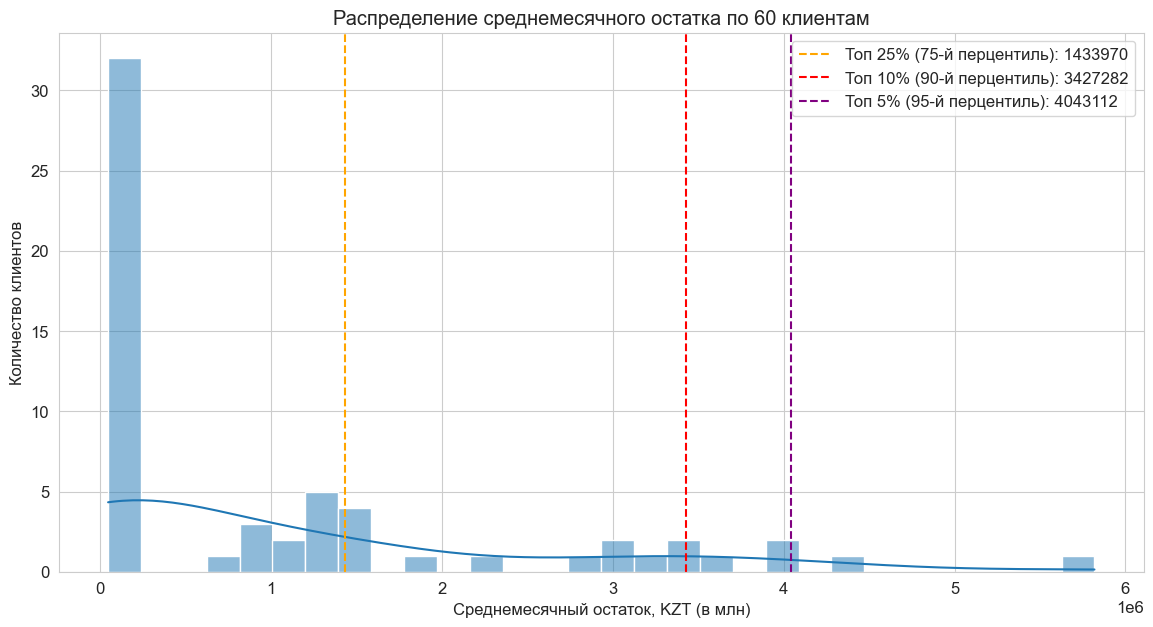

count    6.000000e+01
mean     1.094079e+06
std      1.417719e+06
min      4.663000e+04
25%      8.169800e+04
50%      1.483350e+05
75%      1.433970e+06
90%      3.427282e+06
95%      4.043112e+06
max      5.818675e+06
Name: avg_monthly_balance_KZT, dtype: float64


In [4]:
balance_stats = summary_df['avg_monthly_balance_KZT'].describe(percentiles=[.25, .5, .75, .90, .95])

plt.figure(figsize=(14, 7))
sns.histplot(summary_df['avg_monthly_balance_KZT'], bins=30, kde=True)
plt.title('Распределение среднемесячного остатка по 60 клиентам')
plt.xlabel('Среднемесячный остаток, KZT (в млн)')
plt.ylabel('Количество клиентов')

# Добавим вертикальные линии для квантилей
plt.axvline(balance_stats['75%'], color='orange', linestyle='--', label=f"Топ 25% (75-й перцентиль): {balance_stats['75%']:.0f}")
plt.axvline(balance_stats['90%'], color='red', linestyle='--', label=f"Топ 10% (90-й перцентиль): {balance_stats['90%']:.0f}")
plt.axvline(balance_stats['95%'], color='purple', linestyle='--', label=f"Топ 5% (95-й перцентиль): {balance_stats['95%']:.0f}")
plt.legend()
plt.show()

print(balance_stats)

Мы взяли `avg_monthly_balance_KZT` для каждого из 60 клиентов и посмотрели, как они распределены.  

**Что мы увидели на графике?**  
- **Огромный пик слева**: Большинство клиентов (около 30–35 человек) имеют относительно небольшой остаток (до 500 000 ₸). Это наша *"массовая"* аудитория.  
- **Длинный "хвост" справа**: Есть небольшое количество очень состоятельных клиентов с остатками в 3, 4 и даже 5+ миллионов тенге.  
- **Перцентили (пунктирные линии)**: Мы вычислили точные пороги.  
  - Например, 10% самых богатых клиентов имеют на счету более **3 427 282 ₸**.  

**Что это значит для нашей задачи?**  
Мы можем четко сегментировать клиентов по уровню благосостояния. Теперь мы не будем предлагать *"Золотые слитки"* студенту. Наши пороги стали обоснованными:  
- **Депозит накопительный (начать копить)**: Предлагаем тем, у кого баланс выше среднего (например, `> 1 433 970 ₸`).  
- **Инвестиции / Депозит сберегательный**: Предлагаем только *"топ 10%"* клиентов (`> 3 427 282 ₸`).  


### Анализ 2: Финансовые потоки (`net_flow_3m`)
Сравнивая доходы (`inflows`) и расходы (`outflows`), мы можем выявить клиентов, которые тратят больше, чем получают. Это сигнал о потребности в заемных средствах.

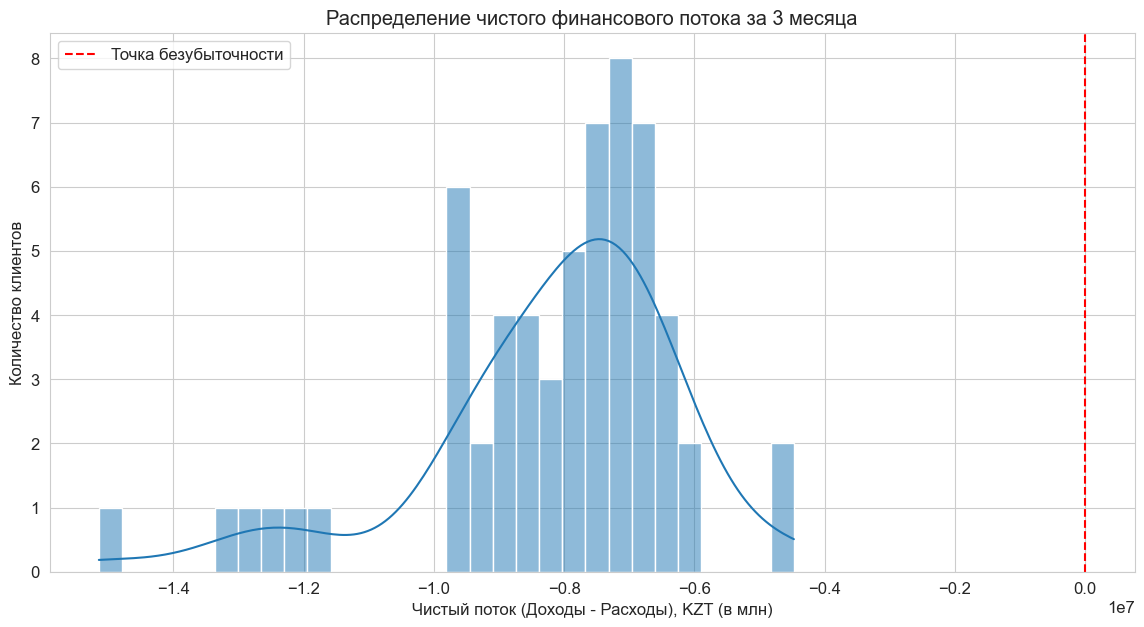

Обнаружено 60 из 60 клиентов (100.0%) с кассовым разрывом.

Статистика по чистому фин. потоку:
count    6.000000e+01
mean    -8.195978e+06
std      1.984550e+06
min     -1.514520e+07
25%     -8.977276e+06
50%     -7.672885e+06
75%     -7.004638e+06
max     -4.473201e+06
Name: net_flow_3m, dtype: float64


In [5]:
clients_with_deficit = summary_df[summary_df['net_flow_3m'] < 0].shape[0]

plt.figure(figsize=(14, 7))
sns.histplot(summary_df['net_flow_3m'], bins=30, kde=True)
plt.title('Распределение чистого финансового потока за 3 месяца')
plt.xlabel('Чистый поток (Доходы - Расходы), KZT (в млн)')
plt.ylabel('Количество клиентов')
plt.axvline(0, color='red', linestyle='--', label='Точка безубыточности')
plt.legend()
plt.show()

print(f"Обнаружено {clients_with_deficit} из {len(summary_df)} клиентов ({clients_with_deficit/len(summary_df):.1%}) с кассовым разрывом.")
print("\nСтатистика по чистому фин. потоку:")
print(summary_df['net_flow_3m'].describe())

Мы посчитали для каждого клиента за 3 месяца: **Все доходы – Все расходы**.  

**Что мы увидели на графике?**  
- **Шокирующий результат**: Вся гистограмма находится слева от красной линии (нуля). Это означает, что АБСОЛЮТНО ВСЕ 60 КЛИЕНТОВ в этой выборке за последние 3 месяца потратили больше денег, чем получили.  
- **Распределение**: Большинство клиентов имеют дефицит от 600 000 до 800 000 ₸ за 3 месяца (или ~200–265 тыс. в месяц).  

**Что это значит для нашей задачи?**  
Потребность в кредитных продуктах — огромна и универсальна для этой группы. Это не просто сигнал, это *крик о помощи*.  
- **Кредитная карта**: Идеальный продукт для управления ежедневным дефицитом и получения кешбэка.  
- **Кредит наличными**: Может быть актуален для тех, у кого дефицит самый большой (столбики слева, `< -1 000 000 ₸`).  


### Анализ 3: Стабильность баланса (`stability_ratio`)
Этот показатель (`доля снятий наличных и p2p / все расходы`) помогает понять, насколько "оседлые" деньги у клиента. Низкий показатель означает, что деньги лежат на счете, что является хорошим сигналом для долгосрочных вкладов.


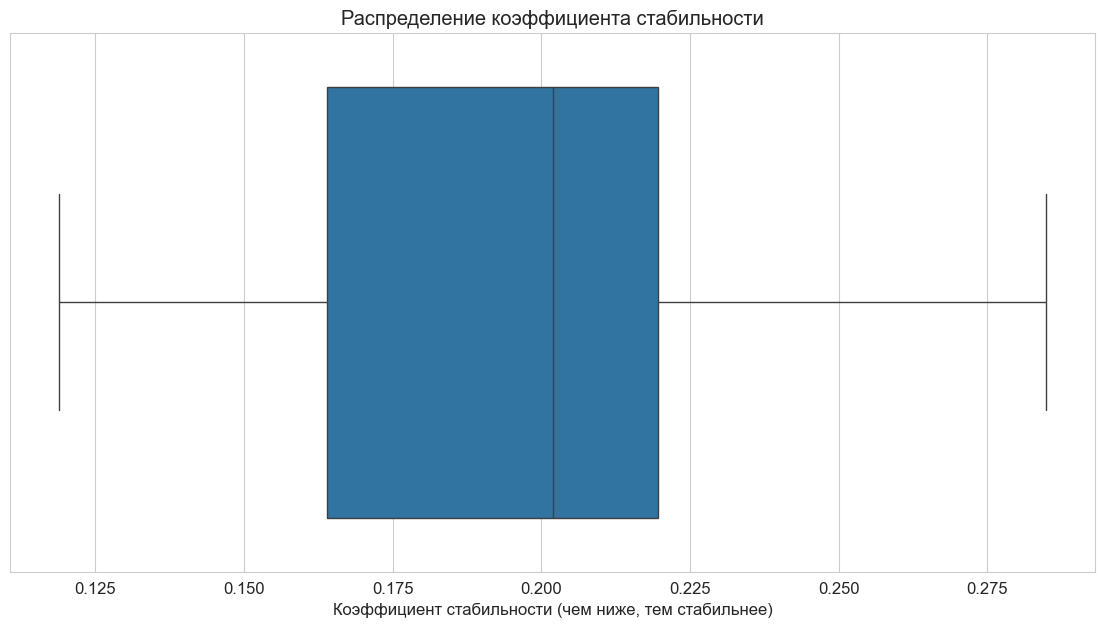

count    60.000000
mean      0.194206
std       0.039772
min       0.118952
25%       0.163949
50%       0.202022
75%       0.219620
max       0.284814
Name: stability_ratio, dtype: float64


In [6]:
stability_stats = summary_df['stability_ratio'].describe()

plt.figure(figsize=(14, 7))
sns.boxplot(x=summary_df['stability_ratio'])
plt.title('Распределение коэффициента стабильности')
plt.xlabel('Коэффициент стабильности (чем ниже, тем стабильнее)')
plt.show()

print(stability_stats)

Мы посчитали, какую долю от всех расходов занимают *"нестабильные"* операции — снятие наличных и p2p-переводы. Чем эта доля ниже, тем "спокойнее" деньги лежат на счету.  

**Что мы увидели на графике (Boxplot)?**  
- **"Коробка"** показывает, что 50% "средних" клиентов тратят на эти операции от 16% до 22% своих денег.  
- **Медиана** (линия в центре коробки) — 21%.  

**Что это значит для нашей задачи?**  
Мы можем найти клиентов, которые не любят "дергать" деньги со счета. Это те, кто находится в **нижних 25%** (коэффициент `< 0.16`).  
- Если у такого клиента ещё и **высокий баланс**, он — идеальный кандидат на *"Депозит сберегательный"* (тот, который с "заморозкой" и максимальной ставкой).  


### Анализ 4: Распространенность прямых сигналов
Здесь мы просто посчитаем, у скольких клиентов в данных есть явные транзакции, указывающие на их потребности: платежи по кредитам, покупка валюты, инвестиции и т.д.

--- Распространенность Прямых Сигналов ---

Клиентов с валютными операциями (fx_buy/sell или траты в USD/EUR): 7 из 60

Частота сигналов в файлах переводов (у скольких клиентов найден каждый тип):


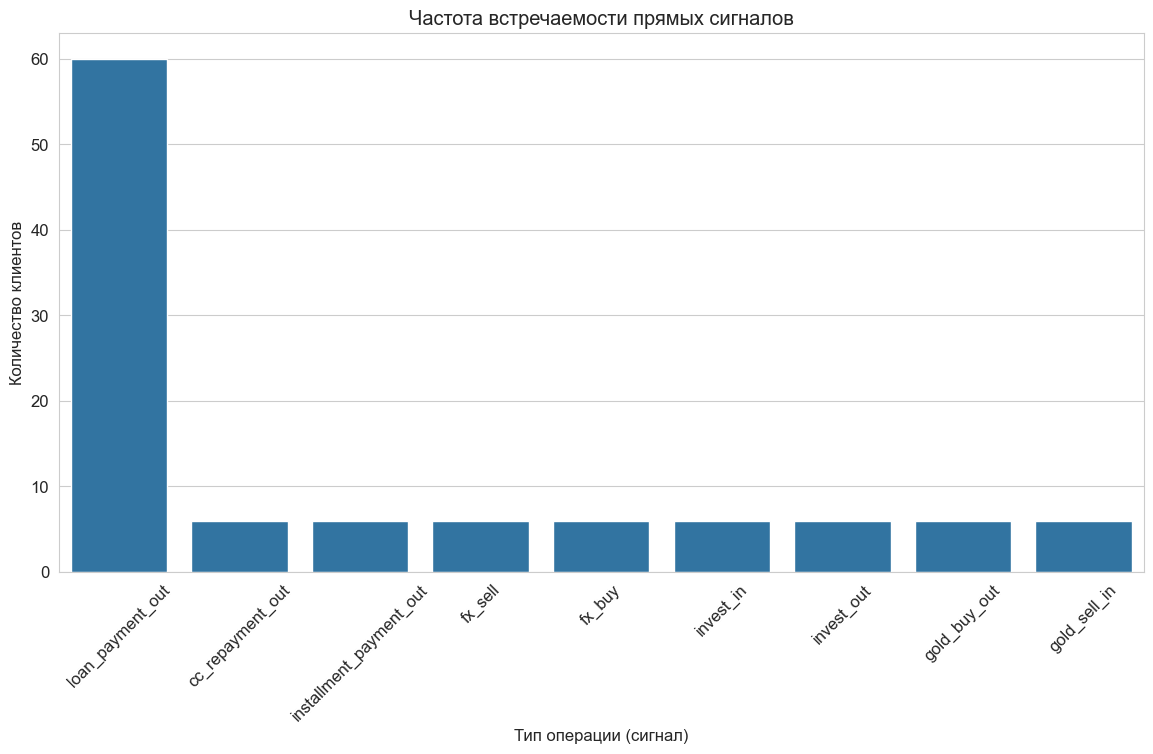

                         client_count
loan_payment_out                   60
cc_repayment_out                    6
installment_payment_out             6
fx_sell                             6
fx_buy                              6
invest_in                           6
invest_out                          6
gold_buy_out                        6
gold_sell_in                        6


In [7]:
fx_clients_count = summary_df['has_fx_activity'].sum()

print("--- Распространенность Прямых Сигналов ---")
print(f"\nКлиентов с валютными операциями (fx_buy/sell или траты в USD/EUR): {fx_clients_count} из {len(summary_df)}")

print("\nЧастота сигналов в файлах переводов (у скольких клиентов найден каждый тип):")
if not direct_signals_counter:
    print("Не найдено ни одного прямого сигнала из списка.")
else:
    # Преобразуем в DataFrame для красивого вывода и графика
    signals_df = pd.DataFrame.from_dict(direct_signals_counter, orient='index', columns=['client_count']).sort_values('client_count', ascending=False)
    
    plt.figure(figsize=(14, 7))
    sns.barplot(x=signals_df.index, y=signals_df['client_count'])
    plt.title('Частота встречаемости прямых сигналов')
    plt.xlabel('Тип операции (сигнал)')
    plt.ylabel('Количество клиентов')
    plt.xticks(rotation=45)
    plt.show()
    
    print(signals_df)

Мы посчитали, у скольких клиентов есть *"железные"* доказательства интереса к продуктам (например, транзакция `loan_payment_out`).  

**Что мы увидели на графике?**  
- `loan_payment_out` есть у **всех 60 клиентов**. Это подтверждает наш вывод из анализа фин. потока: все клиенты уже имеют кредиты и регулярно их платят.  
- Остальные сигналы (`cc_repayment`, `fx_buy`, `invest_in` и т.д.) встречаются гораздо реже, но стабильно — у 6 клиентов каждый.  

**Что это значит для нашей задачи?**  
- Сигнал `loan_payment_out` — наш самый надёжный триггер. Мы можем персонализировать предложение: *"Видим, у вас есть кредит. Попробуйте нашу кредитную карту для удобного управления платежами"*.  
- Для 6 клиентов с `fx_buy`/`fx_sell` мы можем с высокой точностью предложить *"Обмен валют"*.  
- Для 6 клиентов с `invest_in`/`invest_out` мы можем предложить *"Инвестиции"*.  


### Step 3: Scoring system 

In [8]:
import pandas as pd
import os

# --- 1. КОНФИГУРАЦИЯ И ПОРОГИ ---
DATA_PATH = '.'
CLIENTS_FILE = os.path.join(DATA_PATH, 'clients.csv')
OUTPUT_FILE = os.path.join(DATA_PATH, 'product_recommendations_v6_pure_benefit.csv') # Новое имя файла

BALANCE_MID = 1433970
BALANCE_HIGH = 3427282
BALANCE_ULTRA_HIGH = 4043112
STABILITY_THRESHOLD = 0.218

# --- 2. ФУНКЦИИ (без изменений) ---
def load_client_data(client_code, path):
    try:
        trans_file = os.path.join(path, f'client_{client_code}_transactions_3m.csv')
        transfers_file = os.path.join(path, f'client_{client_code}_transfers_3m.csv')
        transactions = pd.read_csv(trans_file)
        transfers = pd.read_csv(transfers_file)
        return transactions, transfers
    except FileNotFoundError: return None, None

def get_client_signals(client_profile, transactions, transfers):
    signals = {}
    signals['client_code'] = client_profile['client_code']
    signals['name'] = client_profile['name']
    signals['avg_monthly_balance'] = client_profile['avg_monthly_balance_KZT']
    spend_by_category = transactions.groupby('category')['amount'].sum()
    signals['travel_spend_3m'] = spend_by_category.reindex(['Путешествия', 'Такси', 'Отели']).sum()
    signals['premium_spend_3m'] = spend_by_category.reindex(['Ювелирные украшения', 'Косметика и Парфюмерия', 'Кафе и рестораны']).sum()
    online_cats = ['Едим дома', 'Смотрим дома', 'Играем дома']
    signals['online_spend_3m'] = spend_by_category.reindex(online_cats).sum()
    top_3_cats = spend_by_category.nlargest(3)
    signals['top_3_cats_list'] = top_3_cats.index.tolist()
    signals['top_3_cats_spend_3m'] = top_3_cats.sum()
    total_inflows = transfers[transfers['direction'] == 'in']['amount'].sum()
    outflows_from_transfers = transfers[transfers['direction'] == 'out']['amount'].sum()
    outflows_from_transactions = transactions['amount'].sum()
    total_outflows = outflows_from_transfers + outflows_from_transactions
    signals['total_outflows_3m'] = total_outflows
    signals['net_flow_3m'] = total_inflows - total_outflows
    transfer_types = set(transfers['type'])
    signals['has_loan_payments'] = bool({'loan_payment_out', 'cc_repayment_out', 'installment_payment_out'}.intersection(transfer_types))
    signals['has_fx_activity'] = bool({'fx_buy', 'fx_sell'}.intersection(transfer_types)) or (transactions['currency'] != 'KZT').any()
    signals['has_invest_activity'] = bool({'invest_out', 'invest_in'}.intersection(transfer_types))
    signals['has_gold_activity'] = bool({'gold_buy_out', 'gold_sell_in'}.intersection(transfer_types))
    signals['cash_deficit'] = signals['net_flow_3m'] < 0 and signals['avg_monthly_balance'] < (signals['total_outflows_3m'] / 3)
    volatile_outflows = transfers[transfers['type'].isin(['atm_withdrawal', 'p2p_out'])]['amount'].sum()
    signals['stability_ratio'] = volatile_outflows / total_outflows if total_outflows > 0 else 0
    signals['atm_withdrawals_amount_3m'] = transfers[transfers['type'] == 'atm_withdrawal']['amount'].sum()
    return signals

def calculate_scores(signals):
    scores = {'client_code': signals['client_code']}
    scores['Карта для путешествий'] = signals['travel_spend_3m'] * 0.04
    if signals['avg_monthly_balance'] > BALANCE_HIGH:
        base_cashback = (signals['total_outflows_3m'] - signals['premium_spend_3m']) * 0.02
        premium_cashback = signals['premium_spend_3m'] * 0.04
        saved_fees = signals['atm_withdrawals_amount_3m'] * 0.01
        scores['Премиальная карта'] = base_cashback + premium_cashback + saved_fees
    else: scores['Премиальная карта'] = 0
    benefit_score = (signals['top_3_cats_spend_3m'] + signals['online_spend_3m']) * 0.10
    need_multiplier = 1.5 if signals['has_loan_payments'] else 1.0
    scores['Кредитная карта'] = benefit_score * need_multiplier
    scores['Обмен валют'] = 10000 if signals['has_fx_activity'] else 0
    scores['Кредит наличными'] = 75000 if signals['cash_deficit'] else 0
    if signals['avg_monthly_balance'] > BALANCE_MID and signals['has_fx_activity']:
        scores['Депозит мультивалютный'] = (signals['avg_monthly_balance'] * 0.13 / 4) + 10000
    else: scores['Депозит мультивалютный'] = 0
    if signals['avg_monthly_balance'] > BALANCE_HIGH and signals['stability_ratio'] < STABILITY_THRESHOLD:
        scores['Депозит сберегательный'] = signals['avg_monthly_balance'] * 0.15 / 4
    else: scores['Депозит сберегательный'] = 0
    if signals['avg_monthly_balance'] > BALANCE_MID:
        scores['Депозит накопительный'] = signals['avg_monthly_balance'] * 0.13 / 4
    else: scores['Депозит накопительный'] = 0
    if signals['avg_monthly_balance'] > BALANCE_HIGH or signals['has_invest_activity']:
        bonus = 2 if signals['has_invest_activity'] else 1
        scores['Инвестиции'] = (signals['avg_monthly_balance'] * 0.05 / 4) * bonus
    else: scores['Инвестиции'] = 0
    if signals['avg_monthly_balance'] > BALANCE_ULTRA_HIGH or signals['has_gold_activity']:
        scores['Золотые слитки'] = 80000
    else: scores['Золотые слитки'] = 0
    return scores

# --- 3. ЛОГИКА V6: "ЧИСТАЯ ВЫГОДА" ---

clients_df = pd.read_csv(CLIENTS_FILE)
raw_scores_list = []
all_signals = {} # Нам все еще нужны сигналы для финального шага - генерации пушей

print("Этап 1: Расчет 'сырых' оценок для всех клиентов...")
for index, client in clients_df.iterrows():
    client_code = client['client_code']
    transactions, transfers = load_client_data(client_code, DATA_PATH)
    if transactions is None: continue
    
    signals = get_client_signals(client, transactions, transfers)
    all_signals[client_code] = signals
    
    scores = calculate_scores(signals)
    raw_scores_list.append(scores)

raw_scores_df = pd.DataFrame(raw_scores_list).set_index('client_code')

print("Этап 2: Нормализация оценок (приведение к шкале 0-100)...")
normalized_scores_df = raw_scores_df.copy()
for col in normalized_scores_df.columns:
    max_val = normalized_scores_df[col].max()
    if max_val > 0:
        normalized_scores_df[col] = (normalized_scores_df[col] / max_val) * 100
    else:
        normalized_scores_df[col] = 0

# --- БЛОК С ВЕСАМИ УДАЛЕН ---

print("Этап 3: Выбор лучшего продукта на основе чистой нормализованной выгоды...")
recommendations = normalized_scores_df.idxmax(axis=1)
recommendations_df = recommendations.reset_index()
recommendations_df.columns = ['client_code', 'recommended_product']

print(f"\nГотово! Рекомендации для {len(recommendations_df)} клиентов сохранены в файл: {OUTPUT_FILE}")
print("\nРаспределение рекомендованных продуктов:")
print(recommendations_df['recommended_product'].value_counts())

Этап 1: Расчет 'сырых' оценок для всех клиентов...
Этап 2: Нормализация оценок (приведение к шкале 0-100)...
Этап 3: Выбор лучшего продукта на основе чистой нормализованной выгоды...

Готово! Рекомендации для 60 клиентов сохранены в файл: .\product_recommendations_v6_pure_benefit.csv

Распределение рекомендованных продуктов:
recommended_product
Кредит наличными          47
Обмен валют                7
Кредитная карта            2
Премиальная карта          1
Депозит сберегательный     1
Карта для путешествий      1
Золотые слитки             1
Name: count, dtype: int64


In [ ]:
# --- Этап 3: Генерация Push-уведомлений с помощью OpenAI (ИСПРАВЛЕННАЯ ВЕРСИЯ 2.0) ---

import pandas as pd
import os
import openai
from getpass import getpass
from tqdm import tqdm

print("Шаг 1: Настройка клиента OpenAI...")

# Безопасный способ настройки API ключа.
try:
    client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
    print(" -> API ключ успешно загружен из переменных окружения.")
except openai.OpenAIError:
    api_key = getpass(" -> API ключ не найден. Введите ваш OpenAI API ключ и нажмите Enter: ")
    client = openai.OpenAI(api_key=api_key)


def create_openai_prompt(product, signals):
    """
    Создает детализированный промпт для OpenAI на основе данных клиента и правил ТЗ.
    """
    name = signals['name'].split()[0]
    
    context = f"- Имя клиента: {name}\n- Рекомендуемый продукт: {product}\n- Ключевые факты о клиенте для персонализации:\n"
    
    if product == 'Карта для путешествий':
        benefit = signals['travel_spend_3m'] * 0.04
        context += f"  - За последние 3 месяца потратил на путешествия, отели и такси: {int(signals['travel_spend_3m']):,} ₸\n".replace(",", " ")
        context += f"  - Потенциальный кешбэк с картой: {int(benefit):,} ₸\n".replace(",", " ")
    elif product == 'Кредитная карта':
        cats = [c.lower().replace('продукты питания', 'продукты') for c in signals['top_3_cats_list']]
        context += f"  - Его самые частые категории трат: {', '.join(cats)}\n"
    elif 'Депозит' in product or product == 'Премиальная карта' or product == 'Инвестиции':
        context += f"  - Его среднемесячный остаток на счете: {int(signals['avg_monthly_balance']):,} ₸\n".replace(",", " ")
    elif product == 'Кредит наличными':
        context += f"  - У клиента наблюдается кассовый разрыв (расходы превышают доходы), что является явной потребностью.\n"
    elif product == 'Обмен валют':
        context += f"  - Клиент совершал операции по покупке/продаже валюты или тратил деньги за рубежом.\n"
        
    prompt = f"""
Ты — копирайтер в банке. Твоя задача — написать короткое, персонализированное и дружелюбное push-уведомление для клиента.

**СТРОГО СОБЛЮДАЙ ПРАВИЛА:**
1.  **Структура:** 1. Персональный контекст (на основе фактов о клиенте). 2. Объяснение пользы продукта. 3. Четкий призыв к действию (2-4 слова).
2.  **Tone of Voice:** На равных, простой, доброжелательный. Обращение на "вы" с маленькой буквы. Без канцеляризмов, пассивного залога и морализаторства.
3.  **Редполитика:** Длина 180-220 символов. БЕЗ КАПСА. Максимум один восклицательный знак (только по делу). Числа форматируй так: 2 490 ₸.
4.  **Призыв к действию (CTA):** Используй глаголы: Открыть, Настроить, Посмотреть, Узнать.
5.  **Не использовать:** Давление, "крикливые" обещания, триггеры дефицита.

**ДАННЫЕ ДЛЯ ПЕРСОНАЛИЗАЦИИ:**
{context}

Напиши только сам текст уведомления, без лишних комментариев и кавычек.
"""
    return prompt

def generate_push_with_openai(product, signals):
    """
    Отправляет запрос к OpenAI и возвращает сгенерированный текст.
    """
    prompt = create_openai_prompt(product, signals)
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "Ты — полезный ассистент-копирайтер для банка, мастерски владеющий русским языком и Tone of Voice."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.7,
            max_tokens=80,
            top_p=1.0,
            frequency_penalty=0.0,
            presence_penalty=0.0
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"  ! Ошибка API OpenAI для клиента {signals['client_code']}: {e}. Используем шаблон.")
        name = signals['name'].split()[0]
        return f"{name}, у нас есть для вас персональное предложение по продукту '{product}'. Узнайте подробности в приложении."


print("\nШаг 2: Начинаем генерацию push-уведомлений...")

final_results = []
for index, row in tqdm(recommendations_df.iterrows(), total=recommendations_df.shape[0], desc="Генерация уведомлений"):
    client_code = row['client_code']
    product = row['recommended_product'] 
    signals = all_signals[client_code]
    
    push_text = generate_push_with_openai(product, signals)
    
    final_results.append({
        'client_code': client_code,
        'product': product,
        'push_notification': push_text
    })


print("\nШаг 3: Формирование и сохранение итогового файла...")

final_output_df = pd.DataFrame(final_results)
final_output_df.to_csv('AI_BCC_Case_1_AI-Sultan_SSagynov.csv', index=False, encoding='utf-8-sig')

print(f"\nГОТОВО! Финальный файл 'final_pushes_openai.csv' с {len(final_output_df)} уведомлениями успешно создан.")
print("\nПример результата:")
print(final_output_df.head().to_markdown(index=False))

Шаг 1: Настройка клиента OpenAI...

Шаг 2: Начинаем генерацию push-уведомлений...


Генерация уведомлений: 100%|██████████| 60/60 [01:42<00:00,  1.71s/it]


Шаг 3: Формирование и сохранение итогового файла...

ГОТОВО! Финальный файл 'final_pushes_openai.csv' с 60 уведомлениями успешно создан.

Пример результата:
|   client_code | product          | push_notification                                                                                                                                                            |
|--------------:|:-----------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|             1 | Кредит наличными | Айгерим, заметили, что ваши расходы превышают доходы? Наш кредит наличными поможет сгладить кассовый разрыв и чувствовать себя увереннее. Узнайте условия сегодня.           |
|             2 | Кредит наличными | Данияр, знаем, что сейчас ваши расходы превышают доходы. Наш кредит наличными поможет вам справиться с кассовым разрывом без лишних забот. Узнать больше.                